# Load libraries and set device up

In [1]:
import numpy    as np
import torch.nn as nn
import os
import torch

import libraries.model   as clm
import libraries.dataset as cld

from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
target = 'EPA'
folder = 'MP-EPA'

target_folder = f'models/{folder}'

In [3]:
files_names = {
    'dataset':            f'{target_folder}/dataset.pt',
    'train_dataset_std':  f'{target_folder}/train_dataset_std.pt',
    'val_dataset_std':    f'{target_folder}/val_dataset_std.pt',
    'test_dataset_std':   f'{target_folder}/test_dataset_std.pt',
    'r_dataset_std':      f'{target_folder}/ref_dataset_std.pt',
    'std_parameters':     f'{target_folder}/standardized_parameters.json',
    'dataset_parameters': f'{target_folder}/dataset_parameters.json',
    'uncertainty_data':   f'{target_folder}/uncertainty_data.json',
    'model':              f'{target_folder}/model.pt',
    'model_parameters':   f'{target_folder}/model_parameters.json'
}
cld.save_json(files_names, f'{target_folder}/files_names.json')

# Define parameters

In [4]:
n_epochs =      300
batch_size =    128
learning_rate = 0.001
dropout =       0.1
patience =      n_epochs
delta =         2
train_ratio =   0.8
test_ratio =    0.1  # val_ratio = 1 - train_ratio - test_ratio

model_parameters = {
    'n_epochs':      n_epochs,
    'batch_size':    batch_size,
    'learning_rate': learning_rate,
    'dropout':       dropout,
    'patience':      patience,
    'delta':         delta,
    'train_ratio':   train_ratio,
    'test_ratio':    test_ratio
}
cld.save_json(model_parameters, files_names['model_parameters'])

# Generate or load graph database for training

In [5]:
# Try loading the training datasets directly, else generate them
try:
    train_dataset_std, val_dataset_std, test_dataset_std, standardized_parameters = cld.load_datasets(files_names)

except FileNotFoundError:
    if not os.path.exists(files_names['dataset']):
        # Generate data
        cld.generate_dataset('datasets/bandgap-MChX',
                             targets=['bandgap'],
                             data_folder=target_folder)

    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(files_names['dataset'], weights_only=False)

    # Load dataset parameters
    dataset_parameters = cld.load_json(files_names['dataset_parameters'])

    # Split datasets
    train_dataset, val_dataset, test_dataset = cld.split_dataset(train_ratio, test_ratio, dataset)
    del dataset  # Free up CUDA memory

    # Standardize train dataset
    train_dataset_std, standardized_parameters = cld.standardize_dataset(train_dataset)
    del train_dataset

    # Standardize test and validation datasets with train parameters
    val_dataset_std  = cld.standardize_dataset_from_keys(val_dataset,  standardized_parameters)
    test_dataset_std = cld.standardize_dataset_from_keys(test_dataset, standardized_parameters)
    del val_dataset, test_dataset

    # Save datasets
    cld.save_datasets(train_dataset_std, val_dataset_std, test_dataset_std, files_names)

    # Save standardized parameters
    cld.save_json(standardized_parameters, files_names['std_parameters'])

# Defining target factor
target_factor = np.array(standardized_parameters['target_std']) / standardized_parameters['scale']
targe_mean    = standardized_parameters['target_mean']

Define data loaders.

In [6]:
train_loader = DataLoader(train_dataset_std, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset_std,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset_std,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset_std[0].num_node_features

# Generate Graph Neural Network model

In [7]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model'], mode='train')
model

DataParallel(
  (module): eGCNN(
    (node_conv1): GraphConv(4, 32)
    (node_conv2): GraphConv(32, 32)
    (edge_linear_f1): Linear(in_features=9, out_features=32, bias=True)
    (edge_linear_r1): Linear(in_features=32, out_features=1, bias=True)
    (conv1): GraphConv(32, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=6, bias=True)
    (lin): Linear(in_features=6, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion

In [8]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = clm.EarlyStopping(patience=patience, delta=delta, model_name=files_names['model'])

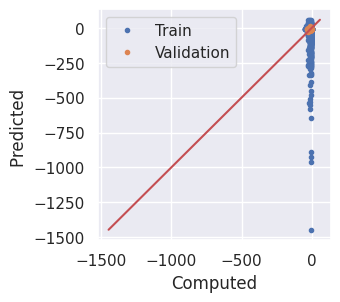

Epoch: 1, Train MAE: 18.6070, Val MAE: 3.3129
Epoch: 2, Train MAE: 3.6549, Val MAE: 3.2127
Epoch: 3, Train MAE: 3.4924, Val MAE: 3.1963
Epoch: 4, Train MAE: 3.4580, Val MAE: 3.1852
Epoch: 5, Train MAE: 3.4074, Val MAE: 3.1719
Epoch: 6, Train MAE: 3.4082, Val MAE: 3.1732
Epoch: 7, Train MAE: 3.4015, Val MAE: 3.1582
Epoch: 8, Train MAE: 3.3825, Val MAE: 3.1501
Epoch: 9, Train MAE: 3.3877, Val MAE: 3.1379
Epoch: 10, Train MAE: 3.3579, Val MAE: 3.1350


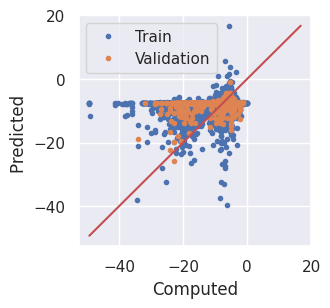

Epoch: 11, Train MAE: 3.3604, Val MAE: 3.1226
Epoch: 12, Train MAE: 3.3335, Val MAE: 3.0965
Epoch: 13, Train MAE: 3.3220, Val MAE: 3.0887
Epoch: 14, Train MAE: 3.2749, Val MAE: 3.0526
Epoch: 15, Train MAE: 3.2555, Val MAE: 3.0616
Epoch: 16, Train MAE: 3.2557, Val MAE: 3.0675
Epoch: 17, Train MAE: 3.2176, Val MAE: 3.0281
Epoch: 18, Train MAE: 3.2001, Val MAE: 2.9964
Epoch: 19, Train MAE: 3.1828, Val MAE: 2.9602
Epoch: 20, Train MAE: 3.1704, Val MAE: 2.9496


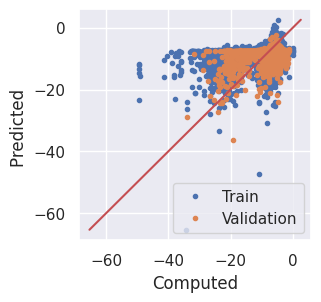

Epoch: 21, Train MAE: 3.1640, Val MAE: 3.0200
Epoch: 22, Train MAE: 3.1563, Val MAE: 2.9724
Epoch: 23, Train MAE: 3.1480, Val MAE: 2.9593
Epoch: 24, Train MAE: 3.1242, Val MAE: 2.9304
Epoch: 25, Train MAE: 3.0999, Val MAE: 2.9325
Epoch: 26, Train MAE: 3.1158, Val MAE: 2.9136
Epoch: 27, Train MAE: 3.0962, Val MAE: 2.9044
Epoch: 28, Train MAE: 3.0780, Val MAE: 2.9071
Epoch: 29, Train MAE: 3.0895, Val MAE: 2.8827
Epoch: 30, Train MAE: 3.0653, Val MAE: 2.8698


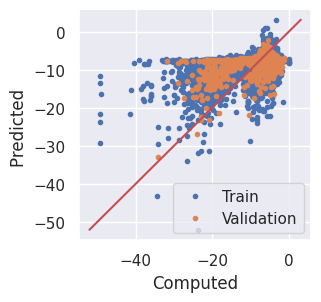

Epoch: 31, Train MAE: 3.0596, Val MAE: 2.8895
Epoch: 32, Train MAE: 3.0456, Val MAE: 2.8774
Epoch: 33, Train MAE: 3.0637, Val MAE: 2.8966
Epoch: 34, Train MAE: 3.1057, Val MAE: 2.8620
Epoch: 35, Train MAE: 3.0442, Val MAE: 2.8655
Epoch: 36, Train MAE: 3.0834, Val MAE: 2.9208
Epoch: 37, Train MAE: 3.0143, Val MAE: 2.8855
Epoch: 38, Train MAE: 2.9900, Val MAE: 2.8518
Epoch: 39, Train MAE: 3.1864, Val MAE: 2.8915
Epoch: 40, Train MAE: 3.0486, Val MAE: 2.9085


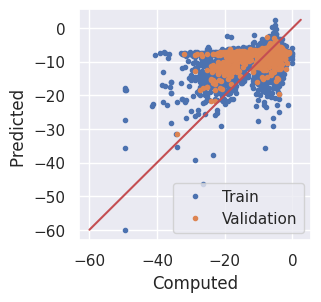

Epoch: 41, Train MAE: 3.0608, Val MAE: 2.8450
Epoch: 42, Train MAE: 2.9766, Val MAE: 2.8681
Epoch: 43, Train MAE: 2.9474, Val MAE: 2.8127
Epoch: 44, Train MAE: 2.9843, Val MAE: 2.7854
Epoch: 45, Train MAE: 2.9402, Val MAE: 2.7725
Epoch: 46, Train MAE: 2.9363, Val MAE: 2.7570
Epoch: 47, Train MAE: 2.9182, Val MAE: 2.7867
Epoch: 48, Train MAE: 2.9128, Val MAE: 2.7684
Epoch: 49, Train MAE: 2.9278, Val MAE: 2.7659
Epoch: 50, Train MAE: 2.9045, Val MAE: 2.8357


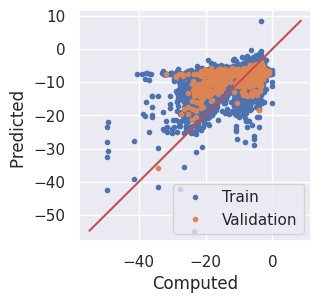

Epoch: 51, Train MAE: 2.8983, Val MAE: 2.8101
Epoch: 52, Train MAE: 2.8736, Val MAE: 2.7389
Epoch: 53, Train MAE: 2.8822, Val MAE: 2.7657
Epoch: 54, Train MAE: 2.8681, Val MAE: 2.7428
Epoch: 55, Train MAE: 2.8534, Val MAE: 2.7377
Epoch: 56, Train MAE: 2.8435, Val MAE: 2.7279
Epoch: 57, Train MAE: 2.8255, Val MAE: 2.7012
Epoch: 58, Train MAE: 2.8258, Val MAE: 2.7119
Epoch: 59, Train MAE: 2.8710, Val MAE: 2.7067
Epoch: 60, Train MAE: 2.8286, Val MAE: 2.7146


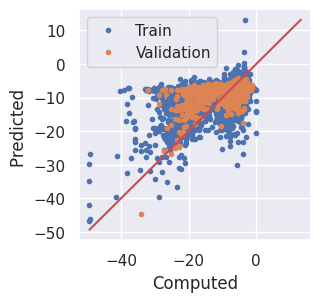

Epoch: 61, Train MAE: 2.8124, Val MAE: 2.6890
Epoch: 62, Train MAE: 2.8175, Val MAE: 2.6868
Epoch: 63, Train MAE: 2.8085, Val MAE: 2.6864
Epoch: 64, Train MAE: 2.8069, Val MAE: 2.7067
Epoch: 65, Train MAE: 2.7933, Val MAE: 2.6375
Epoch: 66, Train MAE: 2.7906, Val MAE: 2.7225
Epoch: 67, Train MAE: 2.7682, Val MAE: 2.6663
Epoch: 68, Train MAE: 2.7755, Val MAE: 2.6231
Epoch: 69, Train MAE: 2.7691, Val MAE: 2.6819
Epoch: 70, Train MAE: 2.7883, Val MAE: 2.6832


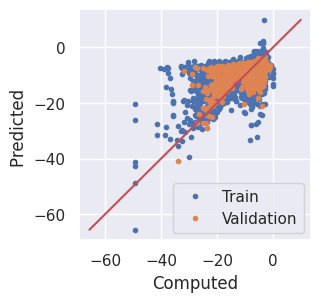

Epoch: 71, Train MAE: 2.7694, Val MAE: 2.6581
Epoch: 72, Train MAE: 2.7518, Val MAE: 2.6536
Epoch: 73, Train MAE: 2.7883, Val MAE: 2.6277
Epoch: 74, Train MAE: 2.7300, Val MAE: 2.6328
Epoch: 75, Train MAE: 2.7370, Val MAE: 2.6608
Epoch: 76, Train MAE: 2.7201, Val MAE: 2.6008
Epoch: 77, Train MAE: 2.7378, Val MAE: 2.6307
Epoch: 78, Train MAE: 2.7470, Val MAE: 2.6806
Epoch: 79, Train MAE: 2.7551, Val MAE: 2.6428
Epoch: 80, Train MAE: 2.7459, Val MAE: 2.6087


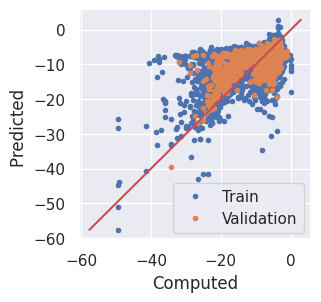

Epoch: 81, Train MAE: 2.7457, Val MAE: 2.6028
Epoch: 82, Train MAE: 2.7216, Val MAE: 2.6116
Epoch: 83, Train MAE: 2.6915, Val MAE: 2.6078
Epoch: 84, Train MAE: 2.7344, Val MAE: 2.5534
Epoch: 85, Train MAE: 2.7037, Val MAE: 2.5611
Epoch: 86, Train MAE: 2.7109, Val MAE: 2.5970
Epoch: 87, Train MAE: 2.6987, Val MAE: 2.5855
Epoch: 88, Train MAE: 2.6767, Val MAE: 2.5463
Epoch: 89, Train MAE: 2.6804, Val MAE: 2.5698
Epoch: 90, Train MAE: 2.6685, Val MAE: 2.5702


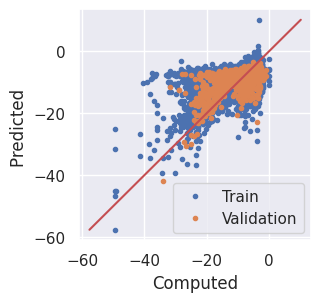

Epoch: 91, Train MAE: 2.6798, Val MAE: 2.5149
Epoch: 92, Train MAE: 2.6588, Val MAE: 2.5686
Epoch: 93, Train MAE: 2.6692, Val MAE: 2.5247
Epoch: 94, Train MAE: 2.6519, Val MAE: 2.5118
Epoch: 95, Train MAE: 2.6890, Val MAE: 2.5466
Epoch: 96, Train MAE: 2.6546, Val MAE: 2.6417
Epoch: 97, Train MAE: 2.6222, Val MAE: 2.5142
Epoch: 98, Train MAE: 2.6467, Val MAE: 2.5593
Epoch: 99, Train MAE: 2.6366, Val MAE: 2.5801
Epoch: 100, Train MAE: 2.6473, Val MAE: 2.5198


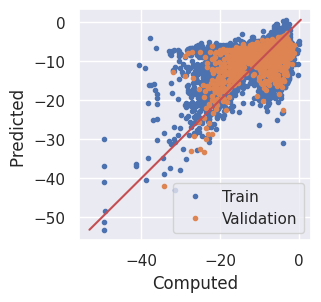

Epoch: 101, Train MAE: 2.6095, Val MAE: 2.5781
Epoch: 102, Train MAE: 2.6153, Val MAE: 2.4945
Epoch: 103, Train MAE: 2.6154, Val MAE: 2.5002
Epoch: 104, Train MAE: 2.6151, Val MAE: 2.5034
Epoch: 105, Train MAE: 2.6082, Val MAE: 2.4986
Epoch: 106, Train MAE: 2.6143, Val MAE: 2.4884
Epoch: 107, Train MAE: 2.6465, Val MAE: 2.5628
Epoch: 108, Train MAE: 2.6425, Val MAE: 2.6229
Epoch: 109, Train MAE: 2.6033, Val MAE: 2.4824
Epoch: 110, Train MAE: 2.5982, Val MAE: 2.4963


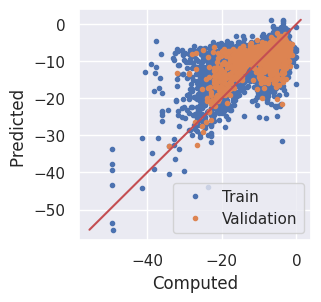

Epoch: 111, Train MAE: 2.6063, Val MAE: 2.5260
Epoch: 112, Train MAE: 2.5866, Val MAE: 2.5181
Epoch: 113, Train MAE: 2.5803, Val MAE: 2.5287
Epoch: 114, Train MAE: 2.6060, Val MAE: 2.5434
Epoch: 115, Train MAE: 2.5919, Val MAE: 2.4884
Epoch: 116, Train MAE: 2.5997, Val MAE: 2.4925
Epoch: 117, Train MAE: 2.6393, Val MAE: 2.5223
Epoch: 118, Train MAE: 2.5826, Val MAE: 2.5068
Epoch: 119, Train MAE: 2.5566, Val MAE: 2.4876
Epoch: 120, Train MAE: 2.5758, Val MAE: 2.4502


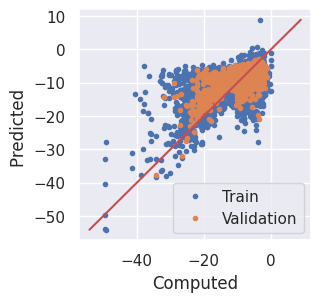

Epoch: 121, Train MAE: 2.5667, Val MAE: 2.4468
Epoch: 122, Train MAE: 2.5317, Val MAE: 2.5015
Epoch: 123, Train MAE: 2.5404, Val MAE: 2.4629
Epoch: 124, Train MAE: 2.5557, Val MAE: 2.5882
Epoch: 125, Train MAE: 2.5804, Val MAE: 2.4690
Epoch: 126, Train MAE: 2.5578, Val MAE: 2.4496
Epoch: 127, Train MAE: 2.5281, Val MAE: 2.4428
Epoch: 128, Train MAE: 2.5186, Val MAE: 2.5364
Epoch: 129, Train MAE: 2.5753, Val MAE: 2.4345
Epoch: 130, Train MAE: 2.5558, Val MAE: 2.5307


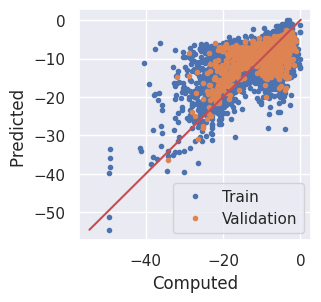

Epoch: 131, Train MAE: 2.5185, Val MAE: 2.4069
Epoch: 132, Train MAE: 2.5294, Val MAE: 2.4304
Epoch: 133, Train MAE: 2.5363, Val MAE: 2.4213
Epoch: 134, Train MAE: 2.5287, Val MAE: 2.4246
Epoch: 135, Train MAE: 2.5030, Val MAE: 2.4521
Epoch: 136, Train MAE: 2.4917, Val MAE: 2.4112
Epoch: 137, Train MAE: 2.5084, Val MAE: 2.4646
Epoch: 138, Train MAE: 2.5911, Val MAE: 2.4212
Epoch: 139, Train MAE: 2.4864, Val MAE: 2.4307
Epoch: 140, Train MAE: 2.4932, Val MAE: 2.4174


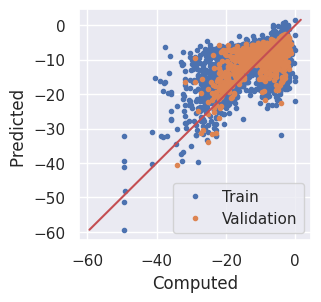

Epoch: 141, Train MAE: 2.5156, Val MAE: 2.4053
Epoch: 142, Train MAE: 2.4976, Val MAE: 2.3939
Epoch: 143, Train MAE: 2.4685, Val MAE: 2.4176
Epoch: 144, Train MAE: 2.4840, Val MAE: 2.4249
Epoch: 145, Train MAE: 2.4876, Val MAE: 2.3975
Epoch: 146, Train MAE: 2.4826, Val MAE: 2.3884
Epoch: 147, Train MAE: 2.4996, Val MAE: 2.5154
Epoch: 148, Train MAE: 2.5006, Val MAE: 2.3817
Epoch: 149, Train MAE: 2.4976, Val MAE: 2.4147
Epoch: 150, Train MAE: 2.4804, Val MAE: 2.3943


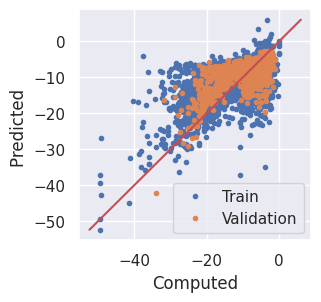

Epoch: 151, Train MAE: 2.5127, Val MAE: 2.4289
Epoch: 152, Train MAE: 2.5371, Val MAE: 2.4942
Epoch: 153, Train MAE: 2.4635, Val MAE: 2.3995
Epoch: 154, Train MAE: 2.4639, Val MAE: 2.4378
Epoch: 155, Train MAE: 2.5419, Val MAE: 2.4255
Epoch: 156, Train MAE: 2.4585, Val MAE: 2.4368
Epoch: 157, Train MAE: 2.4598, Val MAE: 2.4040
Epoch: 158, Train MAE: 2.4422, Val MAE: 2.4013
Epoch: 159, Train MAE: 2.4960, Val MAE: 2.4160
Epoch: 160, Train MAE: 2.6724, Val MAE: 2.4299


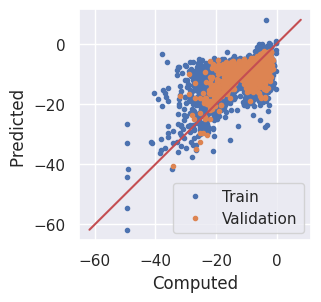

Epoch: 161, Train MAE: 2.5059, Val MAE: 2.3455
Epoch: 162, Train MAE: 2.4615, Val MAE: 2.3838
Epoch: 163, Train MAE: 2.4420, Val MAE: 2.3833
Epoch: 164, Train MAE: 2.5007, Val MAE: 2.3906
Epoch: 165, Train MAE: 2.4839, Val MAE: 2.4023
Epoch: 166, Train MAE: 2.5490, Val MAE: 2.4696
Epoch: 167, Train MAE: 2.4976, Val MAE: 2.4020
Epoch: 168, Train MAE: 2.4429, Val MAE: 2.3723
Epoch: 169, Train MAE: 2.5005, Val MAE: 2.4039
Epoch: 170, Train MAE: 2.4488, Val MAE: 2.3706


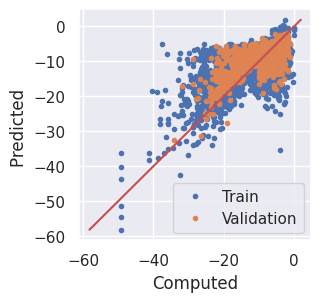

Epoch: 171, Train MAE: 2.4280, Val MAE: 2.3750
Epoch: 172, Train MAE: 2.4879, Val MAE: 2.3833
Epoch: 173, Train MAE: 2.5021, Val MAE: 2.4356
Epoch: 174, Train MAE: 2.4579, Val MAE: 2.4127
Epoch: 175, Train MAE: 2.5078, Val MAE: 2.4171
Epoch: 176, Train MAE: 2.4685, Val MAE: 2.5527
Epoch: 177, Train MAE: 2.9334, Val MAE: 3.0187
Epoch: 178, Train MAE: 3.1010, Val MAE: 2.9837
Epoch: 179, Train MAE: 3.0475, Val MAE: 2.9448
Epoch: 180, Train MAE: 2.7317, Val MAE: 2.4696


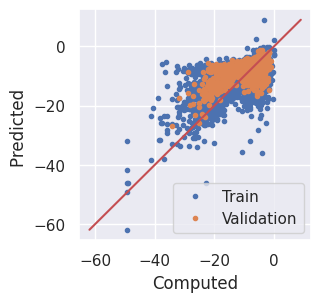

Epoch: 181, Train MAE: 2.5257, Val MAE: 2.5165
Epoch: 182, Train MAE: 2.5051, Val MAE: 2.4012
Epoch: 183, Train MAE: 2.4769, Val MAE: 2.6469
Epoch: 184, Train MAE: 2.5103, Val MAE: 2.3988
Epoch: 185, Train MAE: 2.4471, Val MAE: 2.3754
Epoch: 186, Train MAE: 2.4822, Val MAE: 2.3693
Epoch: 187, Train MAE: 2.4410, Val MAE: 2.3898
Epoch: 188, Train MAE: 2.4876, Val MAE: 2.3769
Epoch: 189, Train MAE: 2.4794, Val MAE: 2.4035
Epoch: 190, Train MAE: 2.4318, Val MAE: 2.3617


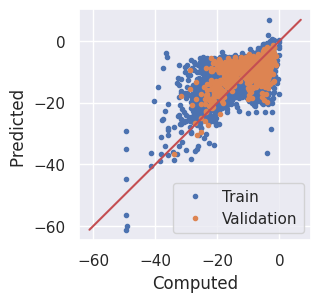

Epoch: 191, Train MAE: 2.4291, Val MAE: 2.3861
Epoch: 192, Train MAE: 2.4690, Val MAE: 2.4322
Epoch: 193, Train MAE: 2.4326, Val MAE: 2.3845
Epoch: 194, Train MAE: 2.5258, Val MAE: 2.4530
Epoch: 195, Train MAE: 2.4708, Val MAE: 2.4348
Epoch: 196, Train MAE: 2.4951, Val MAE: 2.5515
Epoch: 197, Train MAE: 2.4798, Val MAE: 2.4008
Epoch: 198, Train MAE: 3.0179, Val MAE: 2.9467
Epoch: 199, Train MAE: 2.8979, Val MAE: 2.5387
Epoch: 200, Train MAE: 2.5566, Val MAE: 2.5124


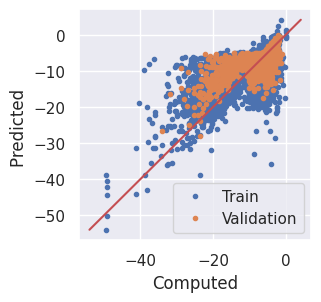

Epoch: 201, Train MAE: 2.4992, Val MAE: 2.4588
Epoch: 202, Train MAE: 2.4835, Val MAE: 2.3770
Epoch: 203, Train MAE: 2.4471, Val MAE: 2.3776
Epoch: 204, Train MAE: 2.4606, Val MAE: 2.4048
Epoch: 205, Train MAE: 2.4336, Val MAE: 2.4566
Epoch: 206, Train MAE: 2.4364, Val MAE: 2.4571
Epoch: 207, Train MAE: 2.4500, Val MAE: 2.3897
Epoch: 208, Train MAE: 2.4337, Val MAE: 2.3676
Epoch: 209, Train MAE: 2.4292, Val MAE: 2.3673
Epoch: 210, Train MAE: 2.3969, Val MAE: 2.3608


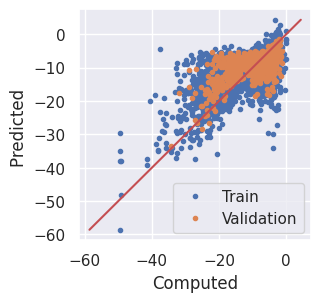

Epoch: 211, Train MAE: 2.4245, Val MAE: 2.3799
Epoch: 212, Train MAE: 2.4185, Val MAE: 2.3532
Epoch: 213, Train MAE: 2.5115, Val MAE: 2.3585
Epoch: 214, Train MAE: 2.4155, Val MAE: 2.4369
Epoch: 215, Train MAE: 2.3987, Val MAE: 2.3519
Epoch: 216, Train MAE: 2.3958, Val MAE: 2.3459
Epoch: 217, Train MAE: 2.4467, Val MAE: 2.3552
Epoch: 218, Train MAE: 2.3953, Val MAE: 2.3923
Epoch: 219, Train MAE: 2.3882, Val MAE: 2.3635
Epoch: 220, Train MAE: 2.4562, Val MAE: 2.4046


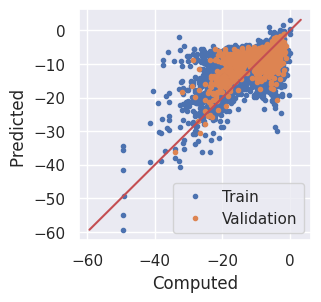

Epoch: 221, Train MAE: 2.4445, Val MAE: 2.3546
Epoch: 222, Train MAE: 2.4173, Val MAE: 2.4968
Epoch: 223, Train MAE: 2.4421, Val MAE: 2.3611
Epoch: 224, Train MAE: 2.4433, Val MAE: 2.3315
Epoch: 225, Train MAE: 2.3904, Val MAE: 2.3573
Epoch: 226, Train MAE: 2.4135, Val MAE: 2.3618
Epoch: 227, Train MAE: 2.4070, Val MAE: 2.3503
Epoch: 228, Train MAE: 2.3856, Val MAE: 2.3786
Epoch: 229, Train MAE: 2.3937, Val MAE: 2.3697
Epoch: 230, Train MAE: 2.4023, Val MAE: 2.3615


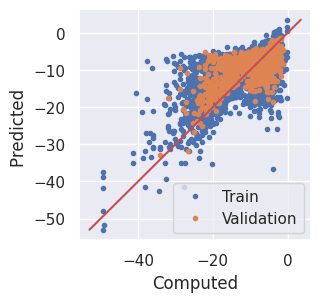

Epoch: 231, Train MAE: 2.4006, Val MAE: 2.3530
Epoch: 232, Train MAE: 2.3914, Val MAE: 2.4218
Epoch: 233, Train MAE: 2.4344, Val MAE: 2.3490
Epoch: 234, Train MAE: 2.4050, Val MAE: 2.3580
Epoch: 235, Train MAE: 2.3983, Val MAE: 2.3643
Epoch: 236, Train MAE: 2.5167, Val MAE: 2.5275
Epoch: 237, Train MAE: 2.4551, Val MAE: 2.4034
Epoch: 238, Train MAE: 2.4200, Val MAE: 2.3783
Epoch: 239, Train MAE: 2.3899, Val MAE: 2.3423
Epoch: 240, Train MAE: 2.3755, Val MAE: 2.3248


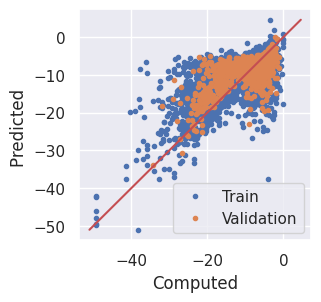

Epoch: 241, Train MAE: 2.4145, Val MAE: 2.3366
Epoch: 242, Train MAE: 2.3763, Val MAE: 2.4179
Epoch: 243, Train MAE: 2.3925, Val MAE: 2.3204
Epoch: 244, Train MAE: 2.4734, Val MAE: 2.3407
Epoch: 245, Train MAE: 2.4219, Val MAE: 2.4058
Epoch: 246, Train MAE: 2.3993, Val MAE: 2.3286
Epoch: 247, Train MAE: 2.8606, Val MAE: 2.9742
Epoch: 248, Train MAE: 3.0264, Val MAE: 2.8659
Epoch: 249, Train MAE: 2.4916, Val MAE: 2.3522
Epoch: 250, Train MAE: 2.6049, Val MAE: 2.3774


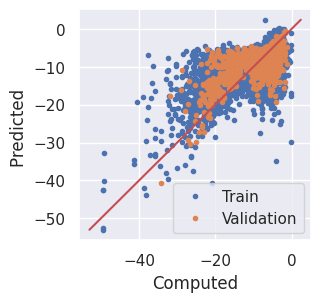

Epoch: 251, Train MAE: 2.4578, Val MAE: 2.3480
Epoch: 252, Train MAE: 2.3948, Val MAE: 2.3591
Epoch: 253, Train MAE: 2.4239, Val MAE: 2.5754
Epoch: 254, Train MAE: 2.3845, Val MAE: 2.3346
Epoch: 255, Train MAE: 2.4208, Val MAE: 2.3175
Epoch: 256, Train MAE: 2.3840, Val MAE: 2.3163
Epoch: 257, Train MAE: 2.3846, Val MAE: 2.3301
Epoch: 258, Train MAE: 2.3681, Val MAE: 2.3206
Epoch: 259, Train MAE: 2.3824, Val MAE: 2.3368
Epoch: 260, Train MAE: 2.4495, Val MAE: 2.3556


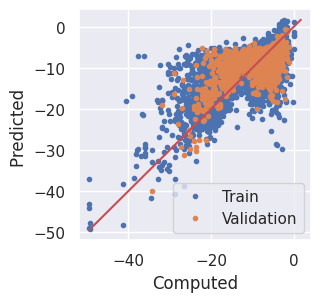

Epoch: 261, Train MAE: 2.3681, Val MAE: 2.3429
Epoch: 262, Train MAE: 2.5652, Val MAE: 2.3891
Epoch: 263, Train MAE: 2.4373, Val MAE: 2.3310
Epoch: 264, Train MAE: 2.4102, Val MAE: 2.3384
Epoch: 265, Train MAE: 2.3692, Val MAE: 2.3373
Epoch: 266, Train MAE: 2.3708, Val MAE: 2.3699
Epoch: 267, Train MAE: 2.3787, Val MAE: 2.3468
Epoch: 268, Train MAE: 2.3774, Val MAE: 2.3353
Epoch: 269, Train MAE: 2.4136, Val MAE: 2.3450
Epoch: 270, Train MAE: 2.3840, Val MAE: 2.3554


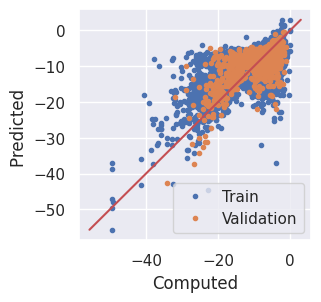

Epoch: 271, Train MAE: 2.4112, Val MAE: 2.3301
Epoch: 272, Train MAE: 2.4358, Val MAE: 2.3567
Epoch: 273, Train MAE: 2.3795, Val MAE: 2.3243
Epoch: 274, Train MAE: 2.3832, Val MAE: 2.3090
Epoch: 275, Train MAE: 2.3569, Val MAE: 2.3747
Epoch: 276, Train MAE: 2.4033, Val MAE: 2.3026
Epoch: 277, Train MAE: 2.3412, Val MAE: 2.3953
Epoch: 278, Train MAE: 2.4142, Val MAE: 2.3430
Epoch: 279, Train MAE: 2.3876, Val MAE: 2.3942
Epoch: 280, Train MAE: 2.3628, Val MAE: 2.3345


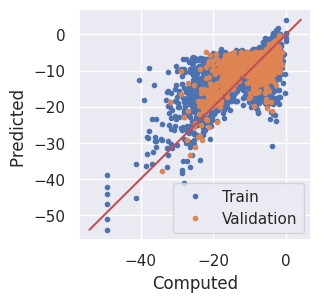

Epoch: 281, Train MAE: 2.3682, Val MAE: 2.3237
Epoch: 282, Train MAE: 2.3498, Val MAE: 2.4082
Epoch: 283, Train MAE: 2.4463, Val MAE: 2.3604
Epoch: 284, Train MAE: 2.3901, Val MAE: 2.3495
Epoch: 285, Train MAE: 2.3520, Val MAE: 2.3042
Epoch: 286, Train MAE: 2.3343, Val MAE: 2.2962
Epoch: 287, Train MAE: 2.4632, Val MAE: 2.4622
Epoch: 288, Train MAE: 2.4601, Val MAE: 2.3363
Epoch: 289, Train MAE: 2.3632, Val MAE: 2.2736
Epoch: 290, Train MAE: 2.3528, Val MAE: 2.3352


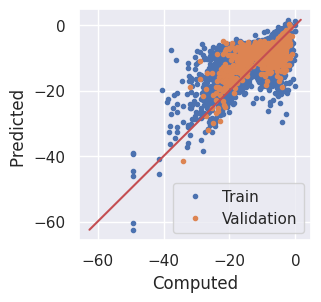

Epoch: 291, Train MAE: 2.3459, Val MAE: 2.2785
Epoch: 292, Train MAE: 2.3539, Val MAE: 2.3143
Epoch: 293, Train MAE: 2.3731, Val MAE: 2.3760
Epoch: 294, Train MAE: 2.4250, Val MAE: 2.5938
Epoch: 295, Train MAE: 2.4518, Val MAE: 2.4002
Epoch: 296, Train MAE: 2.3661, Val MAE: 2.3225
Epoch: 297, Train MAE: 2.3957, Val MAE: 2.3009
Epoch: 298, Train MAE: 2.3265, Val MAE: 2.3141
Epoch: 299, Train MAE: 2.3353, Val MAE: 2.3142
Epoch: 300, Train MAE: 2.3208, Val MAE: 2.3058


In [9]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = clm.train(model, criterion, train_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'],
                                                                   optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'])

    # Convert to original units
    train_loss = np.sum(np.sqrt(train_loss) * target_factor)
    val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)

    if epoch%10 == 0:
        cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                        validation=np.array([val_ground_truths, val_predictions]))
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

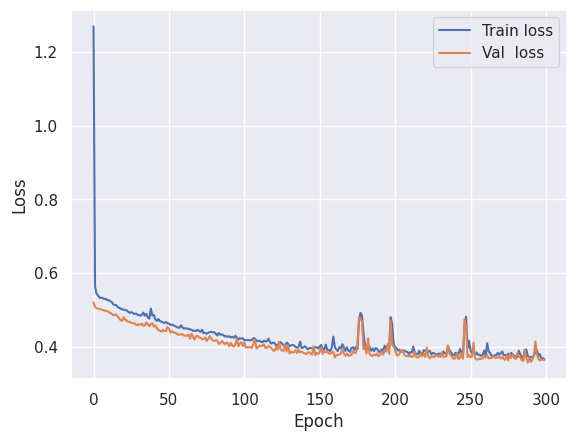

In [10]:
cld.losses_plot(train_losses=train_losses,
                val_losses=val_losses,
                to_log=True)

# Check test data

In [11]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model'], mode='eval')
model

DataParallel(
  (module): eGCNN(
    (node_conv1): GraphConv(4, 32)
    (node_conv2): GraphConv(32, 32)
    (edge_linear_f1): Linear(in_features=9, out_features=32, bias=True)
    (edge_linear_r1): Linear(in_features=32, out_features=1, bias=True)
    (conv1): GraphConv(32, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=6, bias=True)
    (lin): Linear(in_features=6, out_features=1, bias=True)
  )
)

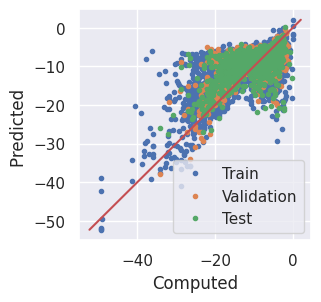

Train MAE: 2.2659, Val MAE: 2.2736, Test MAE: 2.4260


In [12]:
train_loss, train_predictions, train_ground_truths = clm.test(model, criterion, train_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])
val_loss,   val_predictions,   val_ground_truths   = clm.test(model, criterion, val_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])
test_loss,  test_predictions,  test_ground_truths  = clm.test(model, criterion, test_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])

# Pass to energy units (same as initial Fv)
train_loss = np.sum(np.sqrt(train_loss) * target_factor)
val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)
test_loss  = np.sum(np.sqrt(test_loss)  * target_factor)

cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                validation=np.array([val_ground_truths, val_predictions]),
                test=np.array([test_ground_truths, test_predictions]),
                save_to=f'{target_folder}/{target}-GCNN-training.pdf')

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

# Generate uncertainties and save

In [13]:
# Define reference dataset
# This is not necessarily just the full dataset, but it can include any
# additional validation not used as train, test or validation
dataset = [data for dataset in [train_dataset_std, val_dataset_std, test_dataset_std] for data in dataset]

# Save reference dataset
torch.save(dataset, files_names['r_dataset_std'])

# Generate data loader
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


loss, predictions, ground_truths = clm.test(model, criterion, loader,
                                            target_factor,
                                            standardized_parameters['target_mean'])

# label: uncertainty = ground-truth - prediction
uncertainties = ground_truths - predictions

# Standardize for better interpolation
uncert_mean  = uncertainties.mean()
uncert_std   = uncertainties.std()
uncert_scale = 1

uncertainties_std = (uncertainties - uncert_mean) * uncert_scale / uncert_std

# Check all labels are unique, otherwise you should rename them
labels = [data.label for data in dataset]
if len(labels) == len(set(labels)):
    print('All labels are unique')
else:
    print('Error: some labels are duplicated')

# Generate dictionary with uncertainty data
uncertainty_values = {}
for idx in range(len(dataset)):
    uncertainty_values.update(
        {dataset[idx].label: float(uncertainties_std[idx])}
    )
uncertainty_data = {
    'uncertainty_values': uncertainty_values,
    'uncert_mean':        uncert_mean,
    'uncert_std':         uncert_std,
    'uncert_scale':       uncert_scale
}

# Dump the dictionary with numpy arrays to a JSON file
cld.save_json(uncertainty_data, files_names['uncertainty_data'])

All labels are unique
